In [1]:
import sys
sys.path.append('/Users/linggeli/graph_fmri/')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from graph_fmri.cnn_graph import models, graph, coarsening
from graph_fmri.src.helper import prepare_data

In [4]:
X_path = '/Users/linggeli/graph_fmri/clas_data/features_259subjects_filtered.npy'
y_path = '/Users/linggeli/graph_fmri/clas_data/labels_259subjects.npy'
n_coef = 16

In [5]:
brain_regions = np.genfromtxt('/Users/linggeli/graph_fmri/clas_data/brain_regions.csv',
                              dtype=int, delimiter=',')[:40] - 1
X = np.load(X_path)[:, brain_regions, :n_coef]
y = np.load(y_path)

In [6]:
print(X.shape)
print(y.shape)

(1036, 40, 16)
(1036,)


In [7]:
X_train, y_train, X_val, y_val = prepare_data(X, y, 0.7)

In [8]:
from scipy import sparse

In [9]:
adj_matrix = np.genfromtxt('/Users/linggeli/graph_fmri/clas_data/adj_matrix.csv', delimiter=',')
adj_matrix = adj_matrix[brain_regions, :][:, brain_regions]
adj_matrix[np.isnan(adj_matrix)] = 0
print(adj_matrix.shape)

(40, 40)


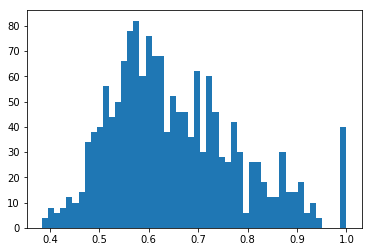

In [10]:
plt.hist(adj_matrix.flatten(), bins=50)
plt.show()

In [11]:
THRES = 0.7

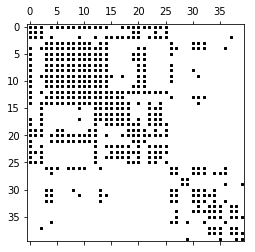

In [12]:
A = adj_matrix.copy()
A[A < THRES] = 0
A = sparse.csr_matrix(A).astype(np.float32)
plt.spy(A, markersize=2, color='black')
plt.show()

In [13]:
graphs, perm = coarsening.coarsen(A, levels=3, self_connections=False)

Layer 0: M_0 = |V| = 48 nodes (8 added),|E| = 241 edges
Layer 1: M_1 = |V| = 24 nodes (3 added),|E| = 94 edges
Layer 2: M_2 = |V| = 12 nodes (1 added),|E| = 33 edges
Layer 3: M_3 = |V| = 6 nodes (0 added),|E| = 14 edges


In [14]:
L = [graph.laplacian(A, normalized=True) for A in graphs]

In [15]:
X_train_list = []
X_val_list = []
for i in range(n_coef):
    X_train_list.append(coarsening.perm_data(X_train[:, :, i], perm))
    X_val_list.append(coarsening.perm_data(X_val[:, :, i], perm))

X_train_perm = np.stack(X_train_list, axis=-1)
X_val_perm = np.stack(X_val_list, axis=-1)

In [16]:
from graph_fmri.src.graph_models import multi_cgcnn

In [17]:
N_FILTER = 30
DENSE_SIZE = 20

In [20]:
params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 50
params['batch_size']     = 20
params['eval_frequency'] = 100

# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'

# Number of classes.
C = y.max() + 1
assert C == np.unique(y).size

# Architecture.
params['F']              = [N_FILTER, N_FILTER]  # Number of graph convolutional filters.
params['K']              = [10, 10]  # Polynomial orders.
params['p']              = [4, 2]    # Pooling sizes.
params['M']              = [DENSE_SIZE, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 5e-4
params['dropout']        = 1.0
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['decay_steps']    = X_train.shape[0] / params['batch_size']

params['n_graph'] = n_coef

In [21]:
model = multi_cgcnn(L, **params)

NN architecture
  input: M_0 = 48
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 48 * 30 / 4 = 360
    weights: F_0 * F_1 * K_1 = 1 * 30 * 10 = 300
    biases: F_1 = 30
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 12 * 30 / 2 = 180
    weights: F_1 * F_2 * K_2 = 30 * 30 * 10 = 9000
    biases: F_2 = 30
  layer 3: fc1
    representation: M_3 = 20
    weights: M_2 * M_3 = 180 * 20 = 3600
    biases: M_3 = 20
  layer 4: logits (softmax)
    representation: M_4 = 2.0
    weights: M_3 * M_4 = 20 * 2.0 = 40.0
    biases: M_4 = 2.0


In [22]:
accuracy, loss, t_step = model.fit(X_train_perm, y_train, X_val_perm, y_val)

KeyboardInterrupt: 